# voting_ensemble_soft

In [5]:
from __future__      import division
from IPython.display import display
from matplotlib      import pyplot as plt
%matplotlib inline

import numpy  as np
import pandas as pd
import random, sys, os

from sklearn.ensemble         import VotingClassifier

from sklearn.ensemble         import GradientBoostingClassifier
from sklearn.ensemble         import ExtraTreesClassifier
from sklearn.linear_model     import LogisticRegression
from sklearn.linear_model     import LogisticRegressionCV
import xgboost as xgb

from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search      import RandomizedSearchCV, GridSearchCV

In [6]:
SEED   = 97
scale  = False 
minmax = False
norm   = False
nointercept = False
engineering = False

submission_filename = "../submissions/submission_voting_ensemble_soft.csv"

# Load the training data

In [7]:
from load_blood_data import load_blood_data

y_train, X_train = load_blood_data(train=True, SEED   = SEED, 
                                               scale  = scale,
                                               minmax = minmax,
                                               norm   = norm,
                                               nointercept = nointercept,
                                               engineering = engineering)

# Train the model

In [8]:
%%time

random.seed(SEED)

# -------------------------------- estimators ----------------------------------------
gbc = GradientBoostingClassifier(loss                     = 'exponential',
                                 learning_rate            = 0.15, 
                                 n_estimators             = 175, 
                                 max_depth                = 1, 
                                 subsample                = 0.75, 
                                 
                                 min_samples_split        = 2, 
                                 min_samples_leaf         = 1, 
                                 #min_weight_fraction_leaf = 0.0, 
                                 init                     = None, 
                                 random_state             = SEED, 
                                 max_features             = None, 
                                 verbose                  = 0, 
                                 max_leaf_nodes           = None, 
                                 warm_start               = False) 
                                 #presort                  = 'auto')
    
etc = ExtraTreesClassifier(n_estimators             = 10, 
                           criterion                = 'entropy', 
                           max_depth                = 7, 
                           bootstrap                = True, 
                           max_features             = None,
                           
                           min_samples_split        = 2, 
                           min_samples_leaf         = 1, 
                           #min_weight_fraction_leaf = 0.0, 
                            
                           max_leaf_nodes           = None, 
                           oob_score                = False, 
                           n_jobs                   = -1, 
                           random_state             = SEED, 
                           verbose                  = 0) 
                           #warm_start               = False, 
                           #class_weight             = None)
        
xgbc = xgb.XGBClassifier(learning_rate    = 0.1,
                         n_estimators     = 50, 
                         max_depth        = 5,
                         subsample        = 0.25,
                         colsample_bytree = 0.75,
                         gamma            = 0, 
                        
                         nthread          = 1, 
                         objective        = 'binary:logistic', 
                         min_child_weight = 1, 
                         max_delta_step   = 0, 
                         base_score       = 0.5, 
                         seed             = SEED,
                         silent           = True,
                         missing          = None)

logit = LogisticRegression(penalty           = 'l2',          
                         dual              = False, 
                         C                 = 0.001, 
                         fit_intercept     = True,
                         solver            = 'liblinear',   
                         max_iter          = 50, 
                         intercept_scaling = 1,
                         
                         tol               = 0.0001, 
                         class_weight      = None, 
                         random_state      = SEED, 
                         multi_class       = 'ovr', 
                         verbose           = 0, 
                         warm_start        = False, 
                         n_jobs            = -1)

logitCV = LogisticRegressionCV(Cs            = 10, 
                           cv                = 10,
                           
                           fit_intercept     = True, 
                           penalty           = 'l2',
                           solver            = 'liblinear', 
                           max_iter          = 50,
                            
                           dual              = False, 
                           scoring           = None, 
                           tol               = 0.0001, 
                           class_weight      = None, 
                           n_jobs            = -1, 
                           verbose           = 0, 
                           refit             = True, 
                           intercept_scaling = 1.0, 
                           multi_class       = 'ovr', 
                           random_state      = SEED)

# -------------------------------- VotingClassifier ----------------------------------------

estimator_list = [('gbc', gbc), ('etc', etc), ('xgbc', xgbc), ('logit', logit), ('logitCV',logitCV)]
weights_list   = [      1,            1,             1,               1,                  1]

clf = VotingClassifier(estimators = estimator_list, 
                       voting     = 'soft', 
                       weights    = weights_list)

clf.fit(X_train, y_train)

CPU times: user 152 ms, sys: 16 ms, total: 168 ms
Wall time: 375 ms


In [9]:
# from sklearn_utilities import GridSearchHeatmap

# GridSearchHeatmap(grid_clf, y_key='learning_rate', x_key='n_estimators')

# from sklearn_utilities import plot_validation_curves

# plot_validation_curves(grid_clf, param_grid, X_train, y_train, ylim = (0.0, 1.05))

/home/george/.local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:1583: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for label in iter_labels
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:1583: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for label in iter_labels
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:1583: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for label in iter_labels
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:1583: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for label in iter_

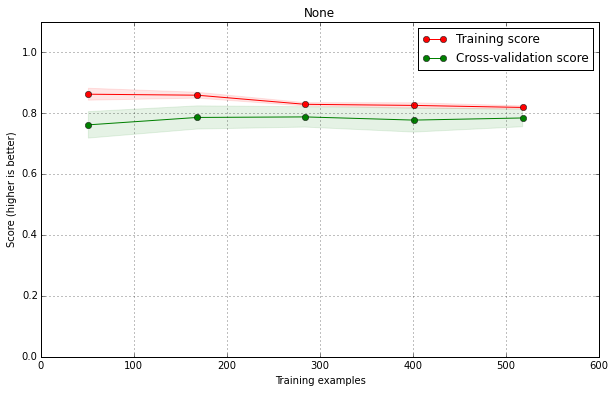

CPU times: user 436 ms, sys: 76 ms, total: 512 ms
Wall time: 4.02 s


In [10]:
%%time

try:
    from sklearn_utilities import plot_learning_curve
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_learning_curve

plot_learning_curve(estimator   = clf, 
                    title       = None, 
                    X           = X_train, 
                    y           = y_train, 
                    ylim        = (0.0, 1.10), 
                    cv          = StratifiedKFold(y            = y_train, 
                                                  n_folds      = 10, 
                                                  shuffle      = True, 
                                                  random_state = SEED), 
                    train_sizes = np.linspace(.1, 1.0, 5),
                    n_jobs      = -1)

plt.show()

# Training set predictions

In [11]:
predicted_values = clf.predict(X_train)
y_true, y_pred   = y_train, predicted_values

try:
    predicted_probs  = clf.predict_proba(X_train)
    probs_avail = True
except AttributeError,e:
    probs_avail = False
    print(e)

[[421  17]
 [ 88  50]]


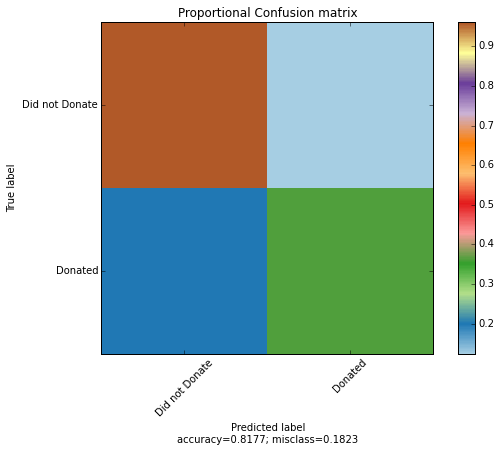

Accuracy 0.8177, mis-class rate 0.1823


In [12]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=None)
print cm

try:
    from sklearn_utilities import plot_confusion_matrix
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_confusion_matrix

plot_confusion_matrix(cm, ['Did not Donate','Donated'])

accuracy = round(np.trace(cm)/float(np.sum(cm)),4)
misclass = 1 - accuracy
print("Accuracy {}, mis-class rate {}".format(accuracy,misclass))

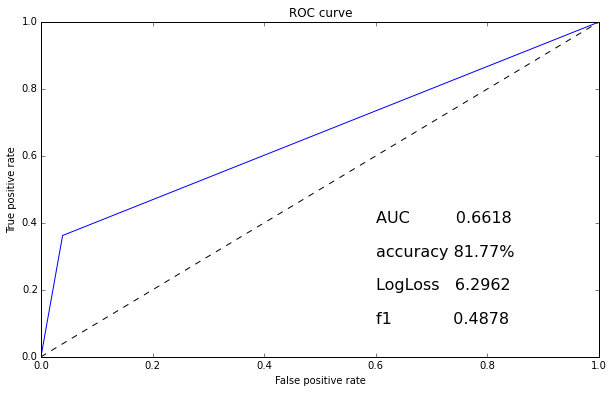

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=None)


plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

plt.text(x=0.6,y=0.4,s="AUC         {:.4f}"\
         .format(roc_auc_score(y_true, y_pred, average='macro')),
        fontsize=16)

plt.text(x=0.6,y=0.3,s="accuracy {:.2f}%"\
         .format(accuracy*100),
        fontsize=16)

plt.text(x=0.6,y=0.2,s="LogLoss   {:.4f}"\
         .format(log_loss(y_true, y_pred)),
        fontsize=16)

plt.text(x=0.6,y=0.1,s="f1            {:.4f}"\
         .format(f1_score(y_true, y_pred)),
        fontsize=16)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

# --------------------------------------------------------------------------------------------

# Test Set Predictions

## Load the test data

In [14]:
from load_blood_data import load_blood_data

X_test, IDs = load_blood_data(train=False, SEED   = SEED, 
                                           scale  = scale,
                                           minmax = minmax,
                                           norm   = norm,
                                           nointercept = nointercept,
                                           engineering = engineering)

# Predict the test set with the fitted model

In [15]:
y_pred        = clf.predict(X_test)
if probs_avail:
    y_pred_probs  = clf.predict_proba(X_test)
    donate_probs  = [prob[1] for prob in y_pred_probs]
else:
    donate_probs = [0.65 if x>0 else 1-0.65 for x in y_pred]

In [16]:
print(y_pred[:10])
if probs_avail: print(y_pred_probs[:10])
print(donate_probs[:10])

[0 0 0 0 1 1 0 0 0 0]
[[ 0.52065332  0.47934668]
 [ 0.84466577  0.15533423]
 [ 0.73423007  0.26576993]
 [ 0.73666519  0.26333481]
 [ 0.45704319  0.54295681]
 [ 0.2177555   0.7822445 ]
 [ 0.65857002  0.34142997]
 [ 0.8944127   0.1055873 ]
 [ 0.98301652  0.01698347]
 [ 0.95714279  0.04285721]]
[0.4793466788957782, 0.15533422833890276, 0.26576993434962909, 0.26333481168168399, 0.54295680807176949, 0.78224449898523907, 0.34142997473035558, 0.10558729782237157, 0.016983470929706299, 0.042857207020129261]


# Create the submission file

In [17]:
assert len(IDs)==len(donate_probs)

f = open(submission_filename, "w")

f.write(",Made Donation in March 2007\n")
for ID, prob in zip(IDs, donate_probs):
    f.write("{},{}\n".format(ID,prob))
    
f.close()